In [1]:
import numpy as np 
import pandas as pd 
#import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### 
https://www.oreilly.com/library/view/ai-and-machine/9781492078180/ch04.html

In [3]:
#!jupyter nbextension enable --py widgetsnbextension

In [4]:
#the first method
(train_dataset, test_dataset), dataset_info = tfds.load('mnist',
                                                        split=["train","test"],
                                                        with_info=True,
                                                        shuffle_files=True)

Metal device set to: Apple M1


2021-10-29 13:44:00.100005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-29 13:44:00.100122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tf.Tensor(4, shape=(), dtype=int64)


2021-10-29 13:44:00.135517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-29 13:44:00.135717: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-29 13:44:00.157999: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


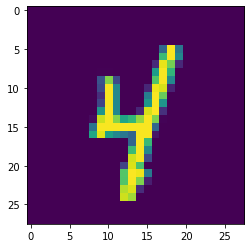

In [5]:
for sample in train_dataset.take(1): #as the take number increases (from 2 to 5), the last bbox related to the last images are shown. 
    image = sample["image"]
    label = sample["label"]
    print(label)
    plt.imshow(image)

In [6]:
#second method
#/home/abaygi/tensorflow_datasets/mnist/3.0.1
(train_dataset, test_dataset), dataset_info = tfds.load("mnist", 
                                                        split=["train", "test"], 
                                                        with_info=True, 
                                                        shuffle_files=True, 
                                                        batch_size=-1, 
                                                        as_supervised=True)

#(training_images, training_labels), (test_images, test_labels)

In [7]:
training_images, training_labels = tfds.as_numpy(train_dataset)

In [8]:
training_images[30].shape

(28, 28, 1)

In [9]:
test_images, test_labels = tfds.as_numpy(test_dataset)

In [10]:
#ds = tfds.load('mnist', split='train', shuffle_files=True)

In [11]:





#dataset_info

In [12]:
#train_dataset

In [13]:
#Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.models import Sequential

In [14]:
training_images.shape

(60000, 28, 28, 1)

In [15]:
test_images.shape

(10000, 28, 28, 1)

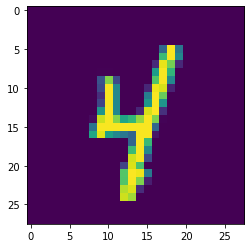

In [16]:
plt.imshow(training_images[0])

### 
In order to use the pre-trained model introduced later in the tutorial, we will need to convert each image into a size of at least (75, 75, 3). Due to the limited RAM, we will use the minimum size. Note that we also have to include three channels instead of just 1 (just copy the same channel 3 times) to make use of the pre-trained weights.

https://www.kaggle.com/saumandas/intro-to-transfer-learning-with-mnist

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)


In [18]:
training_images_75 = [change_size(img) for img in training_images[:10000]]


In [19]:
training_images_75 = np.array(training_images_75)

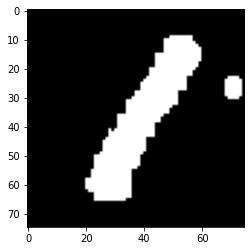

In [20]:
plt.imshow(training_images_75[8])

### Data Augmentation

Data augmentation is one of the most fundamental and useful strategy when dealing with images. It becomes especially useful if we have few images. This is not the case with this dataset, but it will still help anyway. Fortunately, ImageDataGenerator from keras makes it extremely simple to apply these augmentations. However, it is important to be careful when deciding which augmentations to apply.

https://www.kaggle.com/saumandas/intro-to-transfer-learning-with-mnist



In [21]:

image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret numbers in range [0,1]
                              zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split


In [22]:
#dealing with labels

In [23]:

training_labels[0]

4

In [24]:
y = tf.keras.utils.to_categorical(training_labels[:10000]) # one-hot encoding

In [25]:
y[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [26]:
training_images_75.shape

(10000, 75, 75, 3)

In [27]:
train_generator = image_gen.flow(training_images_75, 
                                 y,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(training_images_75,
                                 y,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')

### Transfer Learning

Many features in general images are common and it is not worth starting to train from scratch. Usually the beginning layers in convolutional neural networks identify extremely basic features such as vertical and horizontal lines. This is what forms the backbone of tranfer learning. Using other peoples models, which have been trained on lots of data and are capable of identifying simple features, to fit your own data.

Imagenet

Imagenet is one of the largest image databases in the world! Every year, they host a competition known as the Imagenet Large Scale Visual Recognition Challenge (ILSVRC), where scientists from all over the world compete to create the best model. A couple years back, a group of researchers came up with the ResNet50, and now it's available to everyone! Learn more about the model here: resnet50 info.

### shape_size for ResNet50
In practice, it is best to use this model with image size (224, 224, 3) since the original model was trained with that size. However, for the purpose of this tutorial (75, 75, 3) will also work. Note that we specified the weights as 'imagenet'. This will automatically load those pretrained weights into the model. If we do not specify, the weights will be initialized randomly and we would be starting from scratch

In [28]:
model = Sequential()

#model transfer learing 
model.add(tf.keras.applications.resnet50.ResNet50(input_shape=(75, 75, 3),
                                                 include_top = False, 
                                                 weights = "imagenet"))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [29]:

model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

/Users/abaygi/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [30]:
for layer in model.layers[0].layers:
    print(layer)

In [31]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False


In [32]:
history = model.fit(train_generator,
                   validation_data=valid_generator, 
                   epochs=1)

2021-10-29 13:44:11.933553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.8716

2021-10-29 13:45:13.619194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 68s 263ms/step - loss: 0.4376 - accuracy: 0.8716 - val_loss: 2.6147 - val_accuracy: 0.1700


In [ ]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices()

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [ ]:
model = tf.keras.models.Sequential([
 tf.keras.layers.Flatten(input_shape=(28, 28)),
 tf.keras.layers.Dense(128, activation='relu'),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(10)
])




In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
 loss=loss_fn,
 metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=2)